In [1]:
import numpy as np, os, sys, matplotlib.pyplot as plt, seaborn as sns, pandas

In [2]:
def get_dict_of_arrays(exp_model_dict, read_directory='../log_calculations/unified_outputs/', fname_to_read='pppl.npy',convert_for_plot=True):
    np_arrays = {}
    
    for exp, models in exp_model_dict.items():
        for model in models:
            file_name = os.path.join(read_directory, exp, model, fname_to_read)
            if convert_for_plot:
                np_arrays[model] = get_xy(np.load(file_name))
            else:
                np_arrays[model] = np.load(file_name)

    return np_arrays

In [3]:
def get_dict_of_df(df_dict, read_directory='../log_calculations/unified_outputs/', fname_to_read='filtered_df.csv'):
    
    dfs = {}
    
    for exp, models in df_dict.items():
        for model in models:
            file_name = os.path.join(read_directory, exp, model, fname_to_read)
            dfs[model] = pandas.read_csv(file_name)
    return dfs

In [31]:
from tqdm import trange
import requests
def fetch_semantic_scholar_info(corpus_ids = [], paper_ids = [], fields="title,abstract,externalIds,corpusId", max_batch_size=500, output_file = None, verbose=False):

	processed_ids = processed_ids = ['CorpusId:{}'.format(id) for id in corpus_ids] + paper_ids

	returned_objects = {}

	for i in trange(0,len(corpus_ids)+1,max_batch_size):
		to_send = processed_ids[i:i+max_batch_size]

		if len(to_send) == 0:
			continue
	
		if verbose:
			print('Sending following IDS to Semantic Scholar (len {}): {}'.format(len(processed_ids), processed_ids))

		apikey=os.environ.get('SPECTER_API_KEY')
		r = requests.post(
			'https://api.semanticscholar.org/graph/v1/paper/batch',
			params={'fields': fields},
			headers={"x-api-key" : apikey},
			json={"ids" : to_send}
		)

		for resp in r.json():
			if resp is not None and isinstance(resp, dict):
				returned_objects[resp['corpusId']] = resp


	if output_file:
		with open(output_file, 'w') as f:
			json.dump(r.json(), f, indent=2)

	return returned_objects

In [83]:
models = {
    'filter_newline' : ['allenai/scibert_scivocab_cased', 'bert-base-cased', 'roberta-base', 'bert-large-cased'],
    'multilingual' : ['bert-base-multilingual-cased', 'xlm-roberta-base']
}

dfs = get_dict_of_df(models)

corpus_ids = []
for model, df in dfs.items():
    corpus_ids.append(df['corpusid'].values)

corpus_ids = np.unique(np.concatenate(corpus_ids))
print(len(corpus_ids))
external_ids = fetch_semantic_scholar_info(corpus_ids=corpus_ids, fields='corpusId,externalIds')
for model, df in dfs.items():
    df['has_pubmed'] = df['corpusid'].apply(lambda cid: True if (cid in external_ids) and (('PubMed' in external_ids[cid]['externalIds']) or ('PubMedCentral' in external_ids[cid]['externalIds'])) else False)



9133


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [01:22<00:00,  4.34s/it]

[ 82212221  31685335  37429768 ... 256932495 257990226 258384706]
[ 82212221  31685335  37429768 ... 256932495 257990226 258384706]
[ 82212221  31685335  37429768 ... 256932495 257990226 258384706]
[ 82212221  31685335  37429768 ... 256932495 257990226 258384706]
[ 82212221  31685335  37429768 ... 256932495 257990226 258384706]
[ 82212221  31685335  37429768 ... 256932495 257990226 258384706]


In [64]:
def calculate_pppl(arr): # Expects input of shape (sample_size, max_seq_len). Calcualtes over all given samples

    total_tokens = np.sum(~np.isnan(arr))
    total_sum = np.nansum(arr) * -1
    return np.exp(total_sum / total_tokens)   

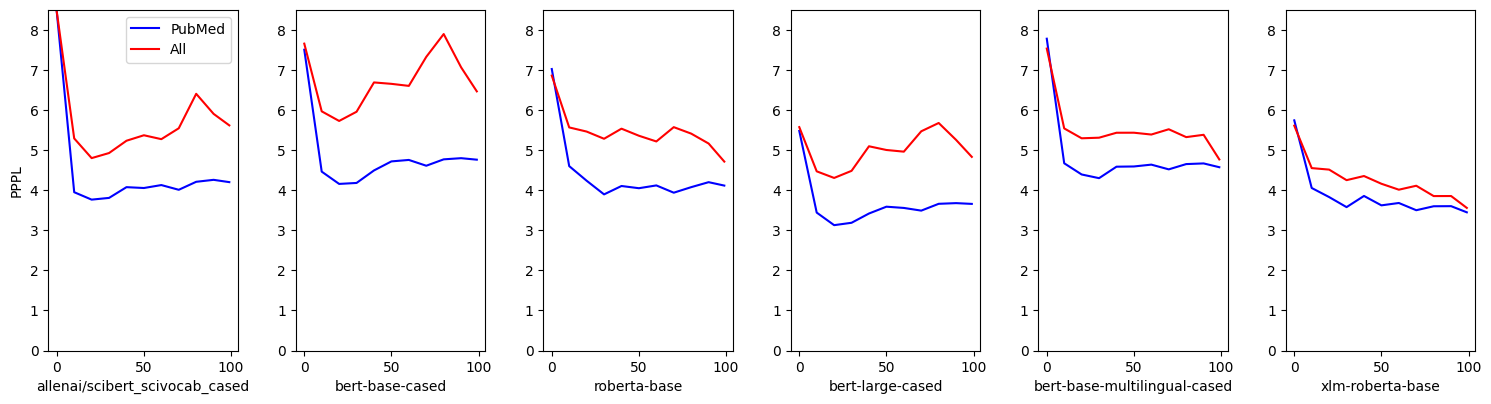

In [105]:
fig, ax = plt.subplots(1,6, figsize=(15,4))
fig.tight_layout()

colors = ['blue', 'red', 'black']

models = {
    'filter_newline' : ['allenai/scibert_scivocab_cased', 'bert-base-cased', 'roberta-base', 'bert-large-cased'],
    'multilingual' : ['bert-base-multilingual-cased', 'xlm-roberta-base']
}

model_nps = get_dict_of_arrays(models, fname_to_read='filtered_log_probs.npy', convert_for_plot=False)

for i, (k,v) in enumerate(dfs.items()):

    arr = model_nps[k]
    
    pubmed_ids = v[v['has_pubmed'] == True][['bin', 'local_id']]
    all_ids = v[['bin', 'local_id']]

    for j, (id_set, name) in enumerate(zip([pubmed_ids, all_ids], ['PubMed', 'All'])):
    
        bins = id_set['bin'].unique()
        vals = np.zeros(bins.shape)
        
        for bin_idx, bin in enumerate(bins):
            local_ids = id_set[id_set['bin'] == bin]['local_id']
            vals[bin_idx] = calculate_pppl(arr[bin, local_ids,:])

        ax[i].plot(bins, vals, label=name, color=colors[j])
        
    ax[i].set_ylim(bottom=0.0, top=8.5)
    ax[i].set_xlabel(k)
ax[0].set_ylabel('PPPL')
ax[0].legend()

In [106]:
print(f"{'Model':35s}\t{'Num PubMed Abstracts'}\t{'Num Total Abstracts'}")
for i, (k,v) in enumerate(dfs.items()):
    print(f"{k:35s}\t{v['has_pubmed'].sum():20d}\t{len(v):19d}")

Model                              	Num PubMed Abstracts	Num Total Abstracts
allenai/scibert_scivocab_cased     	                2036	               8476
bert-base-cased                    	                2089	               8677
roberta-base                       	                2037	               8588
bert-large-cased                   	                2089	               8677
bert-base-multilingual-cased       	                2114	               8790
xlm-roberta-base                   	                2130	               8824


In [107]:
for i, (k,v) in enumerate(dfs.items()):
    print(k)
    print(v.groupby('bin')['has_pubmed'].sum() / v.groupby('bin').size(), end='\n\n')

allenai/scibert_scivocab_cased
bin
0     0.281088
10    0.385802
20    0.328169
30    0.291086
40    0.186722
50    0.157382
60    0.168250
70    0.165865
80    0.182456
90    0.224419
99    0.296788
dtype: float64

bert-base-cased
bin
0     0.278497
10    0.390173
20    0.330201
30    0.288618
40    0.188172
50    0.159892
60    0.164690
70    0.166468
80    0.180139
90    0.223624
99    0.297802
dtype: float64

roberta-base
bin
0     0.272127
10    0.385671
20    0.325069
30    0.281671
40    0.185637
50    0.156463
60    0.162698
70    0.164512
80    0.181818
90    0.222738
99    0.297685
dtype: float64

bert-large-cased
bin
0     0.278497
10    0.390173
20    0.330201
30    0.288618
40    0.188172
50    0.159892
60    0.164690
70    0.166468
80    0.180139
90    0.223624
99    0.297802
dtype: float64

bert-base-multilingual-cased
bin
0     0.284427
10    0.387727
20    0.328947
30    0.285526
40    0.189008
50    0.156373
60    0.160462
70    0.166667
80    0.182030
90    0.222857
